In [548]:
from analytical import *
from analytical import pc_profile as apc
from numerical import pc_profile as npc
from numerical import propag_deputy_and_analysis_col
from mubody.mission import Mission
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
from tqdm.auto import tqdm
import os
import utilities as utl
from astropy_healpix import HEALPix


%load_ext autoreload
%autoreload 2

# %load_ext line_profiler
# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook performs the analysis and plot the results figures of the validation section from the collision risk chapter in the PhD thesis

# Test configuration

In [549]:
#if true, generates chief orbit
generate = True

#if true, saves figures
save = True

#if true saves data, else loads it
save_data = True


#time period
t0 = 0
tf = 86400

#nominal collision risk parameters
#distance between satellites [m]
d = 100

#safety sphere radius [m]
D = 5

#relation between sigmas
q = 0.2

#sigma of lateral velocity component [m/s]
sigma_vv = 3e-4

#Number of cases for monte-carlo analysis
N = 100000
Na = 50

n = 9

#time resolution (time between distance check)
dT = 200

#vector with the mean value of the guassian distribution of each velocity component
mean_vector = np.array([0, 0, 0])

#Relative position
theta = 0
phi = 0

#comments
verbose = True

#type of probability
ptype = 'TP'


#path to store figures
figures_path = 'PhD/Results/validation/figures/'
file_path = 'PhD/Results/validation/data/'

In [550]:
mt = 180 * 86400
orbit_revolutions = mt/(180*86400)
model = 'CRTBP'
opt_iter = 3
chief_orbit_path = 'validation/chief_orbit'
chief_orbit_name = 'chief_orbit_OTM_' + str(opt_iter) + '_' + str(np.round(orbit_revolutions,1)) + '_' + model

chief = Mission(mission_time=mt, SRP_flag=True)
chief.DS.models['CRTBP'].srp.mass = 1000
chief.DS.models['CRTBP'].srp.area = 10

deputy = Mission(mission_time=tf, SRP_flag=True)
deputy.DS.models['CRTBP'].srp.mass = 10
deputy.DS.models['CRTBP'].srp.area = 0.10

if generate:
    chief.OTM(opt_iterations=opt_iter, bar=False, frame='P1-IdealSynodic')
    chief.save(chief_orbit_name, dir_name=chief_orbit_path)
else:
    try:
        chief.load(chief_orbit_name, chief_orbit_path)
    except Exception:
        print("Error, such mission does not exist")

Mission Simulated (CRTBP/Differential corrections) 


Mission successfully saved


In [551]:
default_kwargs = {'t0': t0, 
        'tf' : tf,
        'd' : d, 
        'D' : D,
        'q' : q,
        'sigma_vv' : sigma_vv,
        'N' : N,
        'dT' : dT,
        'ptype' : ptype,
        'depRelVel' : mean_vector,
        'theta' : theta,
        'phi' : phi,
        'chief' : chief,
        'deputy' : deputy,
        'comt' : False,
        'Na' : Na,
        'n' : n,
        't0OrbChief' : 7510000
        }

if save_data:
        os.makedirs(file_path, exist_ok=True)
        file = open(file_path + "/test_conf.txt","w",)
 
        for key, value in default_kwargs.items():
        
                file.write('%s:%s\n' % (key, value))
        
        file.close()


In [552]:
def numeric_sweep(default_kwargs, parameter_name, parameter_list, tag):
    if save_data:
        kwargs = dict(default_kwargs)

        Nbar = len(parameter_list)
        pbar = tqdm(total=Nbar)

        results_sweep_list = []
        
        for p in parameter_list:
            results_sweep_dict = {}

            kwargs[parameter_name] = p

            x, y = npc(**kwargs)

            results_sweep_dict['time'] = x
            results_sweep_dict['TP'] = y[0]
            results_sweep_dict['IP'] = y[1]
            results_sweep_dict[parameter_name] = p
            
            results_sweep_list.append(results_sweep_dict)
            
            pbar.update(1)

        pbar.close()

        results_sweep_df = pd.DataFrame(data=results_sweep_list)

        utl.store(results_sweep_df, tag, file_path)
    else:
        results_sweep_df = utl.recover(tag, file_path)


    return results_sweep_df

def numeric_sweep_double(default_kwargs, parameter_name_1, parameter_list_1, parameter_name_2, parameter_list_2, tag):
    if save_data:
        kwargs = dict(default_kwargs)

        Nbar = len(parameter_list_1)
        pbar = tqdm(total=Nbar)

        results_sweep_list = []
        
        for idx, p in enumerate(parameter_list_1):
            results_sweep_dict = {}

            kwargs[parameter_name_1] = p
            kwargs[parameter_name_2] = parameter_list_2[idx]

            x, y = npc(**kwargs)

            results_sweep_dict['time'] = x
            results_sweep_dict['TP'] = y[0]
            results_sweep_dict['IP'] = y[1]
            results_sweep_dict[parameter_name_1] = p
            results_sweep_dict[parameter_name_2] = parameter_list_2[idx]
            
            results_sweep_list.append(results_sweep_dict)
            
            pbar.update(1)

        pbar.close()

        results_sweep_df = pd.DataFrame(data=results_sweep_list)

        utl.store(results_sweep_df, tag, file_path)
    else:
        results_sweep_df = utl.recover(tag, file_path)

    return results_sweep_df


def analytic_sweep(default_kwargs, parameter_name, parameter_list):

    kwargs = dict(default_kwargs)

    n = len(parameter_list)
    pbar = tqdm(total=n)

    results_sweep_list = []
    
    for p in parameter_list:
        results_sweep_dict = {}

        kwargs[parameter_name] = p

        kwargs['ptype'] = 'IP'
        x, y_ip = apc(**kwargs)
        results_sweep_dict['time'] = x
        results_sweep_dict['IP'] = y_ip

        kwargs['ptype'] = 'TP'
        x, y_tp = apc(**kwargs)
        results_sweep_dict['TP'] = y_tp

        results_sweep_dict[parameter_name] = p
        
        results_sweep_list.append(results_sweep_dict)

        pbar.update(1)

    pbar.close()

    results_sweep_df = pd.DataFrame(data=results_sweep_list)

    return results_sweep_df


def plot_df(df, parameter_name, result='IP', tag=None, save=False, legend_flag=True):
    index = df.index.values
    fig, ax = plt.subplots()
    legend = []

    for ids in index:
        xp = df.iloc[ids]['time']
        yp = df.iloc[ids][result]
        ax.plot(xp, yp)
        legend.append(parameter_name + '=' + str(df.iloc[ids][parameter_name]))
        
    if legend_flag: ax.legend(legend)

    ax.set_title(str(result) + " variation over " + str(parameter_name))

    if save:
        os.makedirs(figures_path, exist_ok=True)
        if tag==None: tag = parameter_name
        fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')


    return fig, ax

In [553]:
parameter_name = 'N'
parameter_list = [1000000]

low_N_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='low_N_nsweep')

100%|██████████| 1/1 [2:46:34<00:00, 9994.47s/it]


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'TP variation over N'}>)

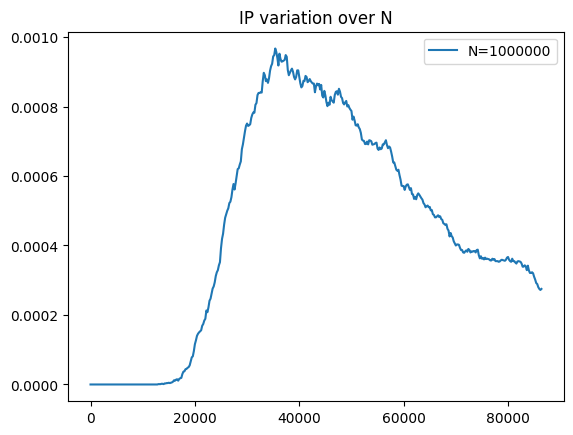

In [554]:
plot_df(low_N_nsweep_df, 'N', result='IP', tag='low_N_nsweep_IP', save=True)
plot_df(low_N_nsweep_df, 'N', result='TP', tag='low_N_nsweep_TP', save=True)

In [555]:
parameter_name = 'n'
parameter_list = [9]

n_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


In [556]:
# plot_df(n_asweep_df, 'n', result='IP', tag='n_asweep_IP', save=True)
# plot_df(n_asweep_df, 'n', result='TP', tag='n_asweep_TP', save=True)

In [557]:
result = 'TP'

x = n_asweep_df.iloc[0]['time']
yn = low_N_nsweep_df.iloc[-1][result]
ya = n_asweep_df.iloc[-1][result]

error_r = np.zeros_like(ya)
error_r_max = np.zeros_like(ya)

for i in range(len(ya)):
    if ya[i]==0:
        error_r[i] = np.nan
        error_r_max[i] = np.nan
    else:
        error_r[i] = 100*abs(yn[i] - ya[i])/ya[i]
        error_r_max[i] = 100*abs(yn[i] - ya[i])/ya.max()


In [558]:
low_N_nsweep_df.time.values[0].shape

(433,)

In [559]:
n_asweep_df.time.values[0].shape

(433,)

In [560]:
# plt.semilogy(yn[ids:ids+100])
# plt.semilogy(ya[ids:ids+100])
# plt.plot(yn[ids:ids+100])


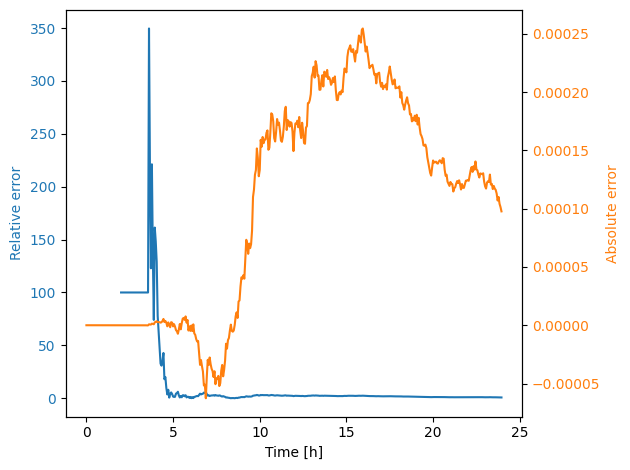

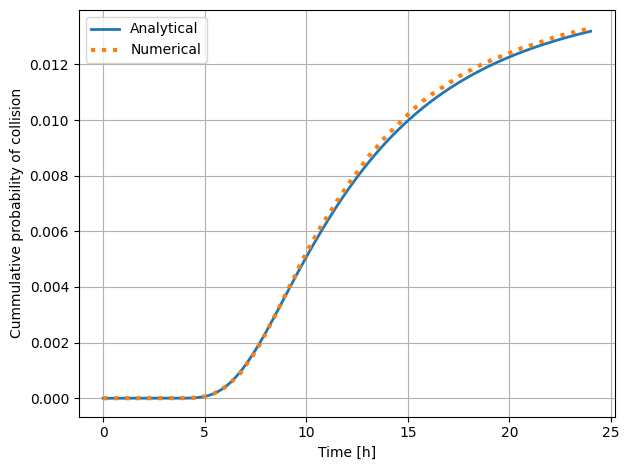

In [561]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ids = 0
# ids = np.where(yn!=0)[0][0] + 2
ide = -1
fig_tp_error, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.set_xlabel('Time [h]')

ax1.plot(x[ids:ide]/3600, error_r[ids:ide], colors[0])
ax2.plot(x[ids:ide]/3600, (yn-ya)[ids:ide], colors[1])

ax2.set_ylabel('Absolute error', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

ax1.set_ylabel('Relative error', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])


fig_tp, ax_tp = plt.subplots()

ax_tp.set_xlabel('Time [h]')

ax_tp.plot(x/3600, ya, linewidth=2)
ax_tp.plot(x/3600, yn, linestyle='dotted', linewidth=3)

ax_tp.set_ylabel('Cummulative probability of collision')
ax_tp.set_xlabel('Time [h]')

ax_tp.legend(['Analytical', 'Numerical'])
ax_tp.grid()

fig_tp.tight_layout()
fig_tp_error.tight_layout()

fig_tp.savefig(figures_path + 'TP_profiles' + '.pdf', dpi=300, format='pdf')
fig_tp_error.savefig(figures_path + 'TP_profiles_error' + '.pdf', dpi=300, format='pdf')

In [562]:
result = 'IP'

x = n_asweep_df.iloc[0]['time']
yn = low_N_nsweep_df.iloc[-1][result]
ya = n_asweep_df.iloc[-1][result]

error_r = np.zeros_like(ya)
error_r_max = np.zeros_like(ya)

for i in range(len(ya)):
    if ya[i]==0:
        error_r[i] = np.nan
        error_r_max[i] = np.nan
    else:
        error_r[i] = 100*abs(yn[i] - ya[i])/ya[i]
        error_r_max[i] = 100*abs(yn[i] - ya[i])/ya.max()

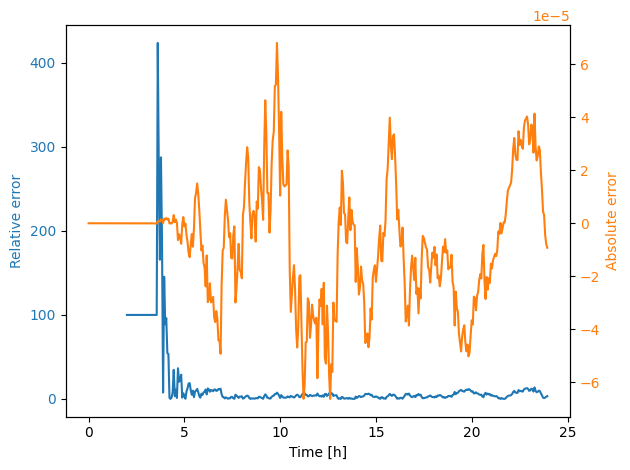

In [563]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ids = 0
# ids = np.where(yn!=0)[0][0] + 2
ide = -1
fig_tp_error, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.set_xlabel('Time [h]')

ax1.plot(x[ids:ide]/3600, error_r[ids:ide], colors[0])
ax2.plot(x[ids:ide]/3600, (yn-ya)[ids:ide], colors[1])

ax2.set_ylabel('Absolute error', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

ax1.set_ylabel('Relative error', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])


fig_tp, ax_tp = plt.subplots()

ax_tp.set_xlabel('Time [h]')

ax_tp.plot(x/3600, ya, linewidth=2)
ax_tp.plot(x/3600, yn, linestyle='dotted', linewidth=3)

ax_tp.set_ylabel('Instantaneous probability of collision')
ax_tp.set_xlabel('Time [h]')

ax_tp.legend(['Analytical', 'Numerical'])
ax_tp.grid()

fig_tp.tight_layout()
fig_tp_error.tight_layout()

fig_tp.savefig(figures_path + 'IP_profiles' + '.pdf', dpi=300, format='pdf')
fig_tp_error.savefig(figures_path + 'IP_profiles_error' + '.pdf', dpi=300, format='pdf')

## Error evolution with N

In [564]:
parameter_name = 'N'
# parameter_list = [5000, 10000, 50000, 100000]
parameter_list_N = [10000, 100000, 1000000]

high_N_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list_N, tag='high_N_nsweep')

100%|██████████| 3/3 [3:03:15<00:00, 3665.31s/it]


C:\Users\juan.bermejo\AppData\Local\Temp\ipykernel_10188\1074245336.py:12: RuntimeWarning: invalid value encountered in divide
  error = 100 * np.abs((yn - ya)/ya)


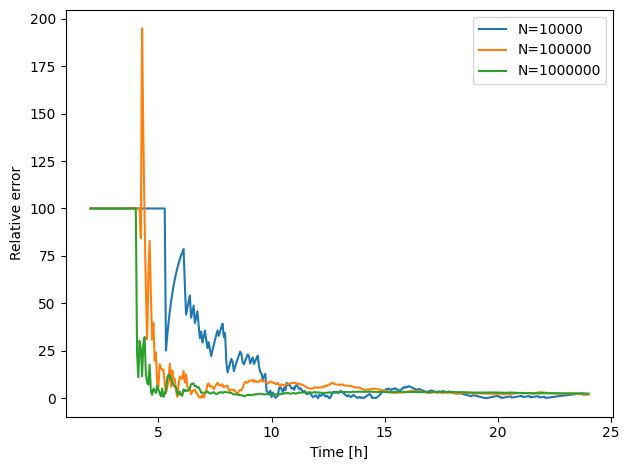

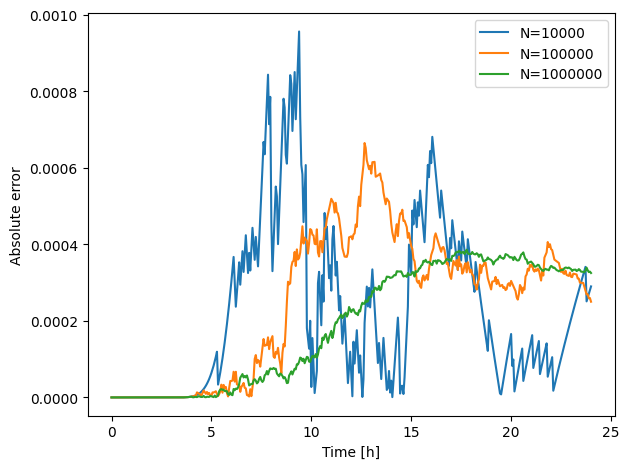

In [565]:
fig_tp_r_N, ax_tp_r_N = plt.subplots()

result = 'TP'

x = n_asweep_df.iloc[0]['time']/3600
ya = n_asweep_df.iloc[-1][result]

legend = []

for i in range(len(parameter_list_N)):
    yn = high_N_nsweep_df.iloc[i][result]
    error = 100 * np.abs((yn - ya)/ya)
    ax_tp_r_N.plot(x, error)
    legend.append('N' + '=' + str(high_N_nsweep_df.iloc[i]['N']))

ax_tp_r_N.legend(legend)

ax_tp_r_N.set_ylabel('Relative error')
ax_tp_r_N.set_xlabel('Time [h]')

fig_tp_N, ax_tp_N = plt.subplots()

result = 'TP'

legend = []

for i in range(len(parameter_list_N)):
    yn = high_N_nsweep_df.iloc[i][result]
    error = np.abs((yn - ya))
    ax_tp_N.plot(x, error)
    legend.append('N' + '=' + str(high_N_nsweep_df.iloc[i]['N']))

ax_tp_N.legend(legend)

ax_tp_N.set_ylabel('Absolute error')
ax_tp_N.set_xlabel('Time [h]')


fig_tp_r_N.tight_layout()
fig_tp_N.tight_layout()

tag = "TP_error_r_N"
fig_tp_r_N.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')

tag = "TP_error_N"
fig_tp_N.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')


C:\Users\juan.bermejo\AppData\Local\Temp\ipykernel_10188\1274410987.py:12: RuntimeWarning: invalid value encountered in divide
  error_r = 100 * np.abs((yn - ya)/ya)


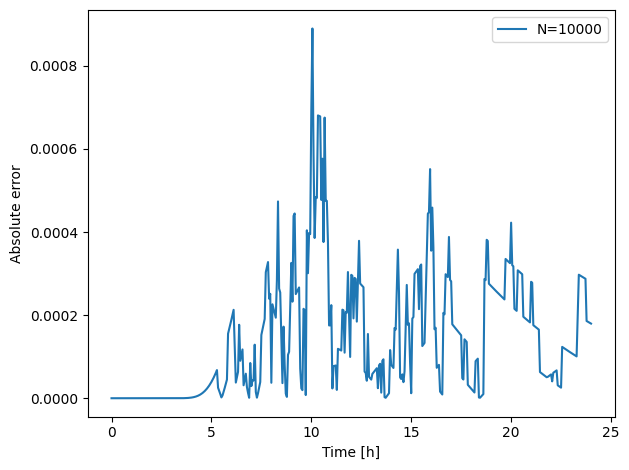

In [566]:
fig_ip_r_N, ax_ip_r_N = plt.subplots()
tag = "IP_error_r_N"
result = 'IP'

x = n_asweep_df.iloc[0]['time']/3600
ya = n_asweep_df.iloc[-1][result]

legend = []

for i in range(len(parameter_list)):
    yn = high_N_nsweep_df.iloc[i][result]
    error_r = 100 * np.abs((yn - ya)/ya)
    ax_ip_r_N.plot(x, error_r)
    legend.append('N' + '=' + str(high_N_nsweep_df.iloc[i]['N']))

ax_ip_r_N.legend(legend)

fig_ip_N, ax_ip_N = plt.subplots()
tag = "IP_error_N"
result = 'IP'

legend = []

for i in range(len(parameter_list)):
    yn = high_N_nsweep_df.iloc[i][result]
    error = np.abs((yn - ya))
    ax_ip_N.plot(x, error)
    legend.append('N' + '=' + str(high_N_nsweep_df.iloc[i]['N']))

ax_ip_N.legend(legend)


ax_ip_N.set_ylabel('Absolute error')
ax_ip_N.set_xlabel('Time [h]')


fig_ip_r_N.tight_layout()
fig_ip_N.tight_layout()

fig_ip_r_N.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')
fig_ip_N.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')

## Sphere errors

In [567]:
parameter_name = 'phi'
parameter_list_phi = np.linspace(-90,90, 5)
parameter_list_theta = np.linspace(-180,180, 9)

deputy.DS.models['CRTBP'].srp.area = 0.1
default_kwargs['N'] = 1000000

phi_df_list = []
deputy.DS.models['CRTBP'].srp.area = 0.10
for theta in parameter_list_theta:
    default_kwargs['theta'] = theta
    
    phi_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list_phi, tag='phi_nsweep')

    phi_df_list.append(phi_nsweep_df)

100%|██████████| 5/5 [13:34:58<00:00, 9779.72s/it]  


In [568]:
parameter_name = 'theta'
parameter_list = [0]

sph_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


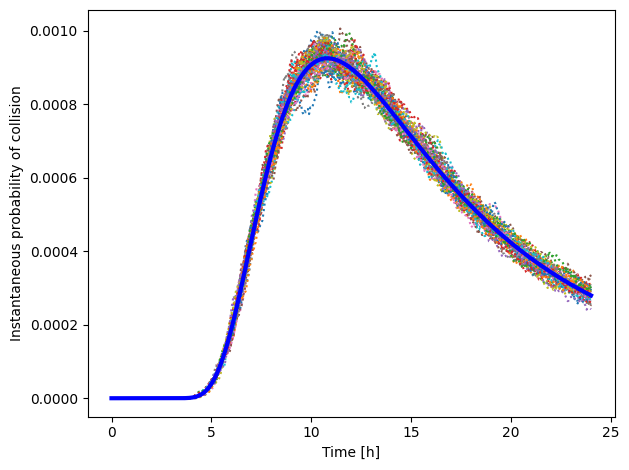

In [569]:

fig_tp_sph, ax_tp_sph = plt.subplots()



xa = sph_asweep_df.iloc[0]['time']/3600


for df in phi_df_list:
    for i in range(len(parameter_list_phi)):
        xn = df.iloc[0]['time']/3600
        ax_tp_sph.plot(xn, df.iloc[i]['TP'], linestyle='dotted', linewidth='1.5')
ax_tp_sph.plot(xa, sph_asweep_df.iloc[-1]['TP'], linewidth='3', color='b')

ax_tp_sph.set_ylabel('Cumulative probability of collision')
ax_tp_sph.set_xlabel('Time [h]')



fig_ip_sph, ax_ip_sph = plt.subplots()




for df in phi_df_list:
    for i in range(len(parameter_list_phi)):
        ax_ip_sph.plot(xn, df.iloc[i]['IP'], linestyle='dotted', linewidth='1.5')

ax_ip_sph.plot(xa, sph_asweep_df.iloc[-1]['IP'], linewidth='3', color='b')

ax_ip_sph.set_ylabel('Instantaneous probability of collision')
ax_ip_sph.set_xlabel('Time [h]')


fig_tp_sph.tight_layout()
fig_ip_sph.tight_layout()

tag = 'TP_sphere'
fig_tp_sph.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')

tag = 'IP_sphere'
fig_ip_sph.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')


# High fidelity dynamics 

In [570]:
default_kwargs

{'t0': 0,
 'tf': 86400,
 'd': 100,
 'D': 5,
 'q': 0.2,
 'sigma_vv': 0.0003,
 'N': 1000000,
 'dT': 200,
 'ptype': 'TP',
 'depRelVel': array([0, 0, 0]),
 'theta': 180.0,
 'phi': 0,
 'chief': <mubody.mission.Mission at 0x130ca563700>,
 'deputy': <mubody.mission.Mission at 0x130ca5636a0>,
 'comt': False,
 'Na': 50,
 'n': 9,
 't0OrbChief': 7510000}

In [571]:
default_kwargs['D'] = 5

In [572]:
areas_list = [0.08, 0.1, 0.12]
areas_df = []
parameter_name ='N'
parameter_list = [1000000]

for area in areas_list:
    deputy.DS.models['CRTBP'].srp.area = area
    
    df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='N_sweep')
    areas_df.append(df)


100%|██████████| 1/1 [2:43:05<00:00, 9785.69s/it]


In [573]:
parameter_name = 'N'
parameter_list = [500000]
areas_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


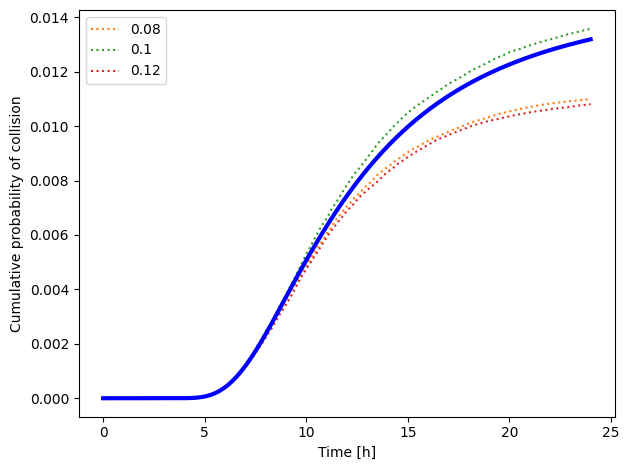

In [574]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_tp_models, ax_tp_models = plt.subplots()

x = areas_df[0].iloc[0]['time']/3600

legend = []

for i in range(len(areas_list)):
    y = areas_df[i].iloc[0]['TP']
    ax_tp_models.plot(x, y, linestyle='dotted', color=colors[i+1])
    legend.append(str(areas_list[i]))
    # ax_tp_models.plot(xa, areas_asweep_df.iloc[i]['TP'], color=colors[i])

ax_tp_models.legend(legend)

ax_tp_models.plot(xa, areas_asweep_df.iloc[-1]['TP'], linewidth='3', color='b')


ax_tp_models.set_ylabel('Cumulative probability of collision')
ax_tp_models.set_xlabel('Time [h]')


fig_tp_models.tight_layout()

tag = 'TP_srp'
fig_tp_models.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')


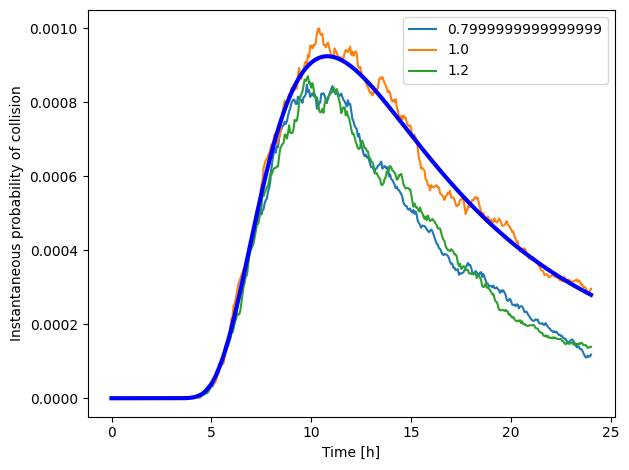

In [575]:
fig_ip_models, ax_ip_models = plt.subplots()

x = areas_df[0].iloc[0]['time']/3600

legend = []

for i in range(len(areas_list)):
    y = areas_df[i].iloc[0]['IP']
    ax_ip_models.plot(x, y)
    legend.append(str(areas_list[i]/0.1))

ax_ip_models.legend(legend)

ax_ip_models.plot(xa, areas_asweep_df.iloc[-1]['IP'], linewidth='3', color='b')


ax_ip_models.set_ylabel('Instantaneous probability of collision')
ax_ip_models.set_xlabel('Time [h]')


fig_ip_models.tight_layout()

tag = 'IP_srp'
fig_ip_models.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')

In [576]:
np.array(areas_list)/0.1

array([0.8, 1. , 1.2])

In [577]:
parameter_name = 'phi'
parameter_list_phi = np.linspace(-90,90, 5)
parameter_list_theta = np.linspace(-180,180, 9)

deputy.DS.models['CRTBP'].srp.area = 0.12
default_kwargs['N'] = 1000000

phi_df_list = []
deputy.DS.models['CRTBP'].srp.area = 0.10
for theta in parameter_list_theta:
    default_kwargs['theta'] = theta
    
    phi_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list_phi, tag='phi_nsweep')

    phi_df_list.append(phi_nsweep_df)

 40%|████      | 2/5 [5:30:54<8:16:21, 9927.07s/it] 

MemoryError: 

In [ ]:
parameter_name = 'theta'
parameter_list = [0]

sph_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


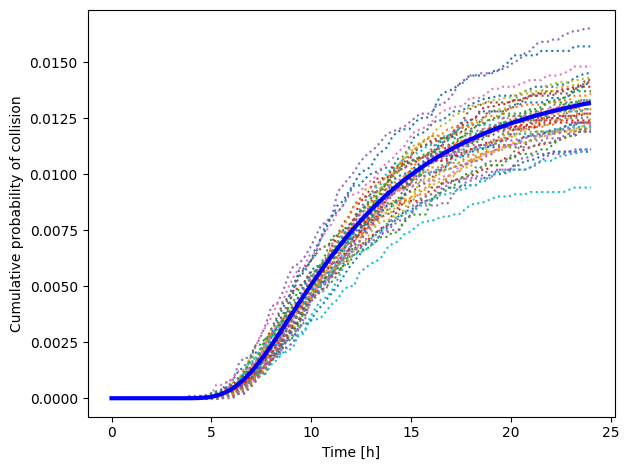

In [ ]:

fig_tp_sph, ax_tp_sph = plt.subplots()



xa = sph_asweep_df.iloc[0]['time']/3600


for df in phi_df_list:
    for i in range(len(parameter_list_phi)):
        xn = df.iloc[0]['time']/3600
        ax_tp_sph.plot(xn, df.iloc[i]['TP'], linestyle='dotted', linewidth='1.5')
ax_tp_sph.plot(xa, sph_asweep_df.iloc[-1]['TP'], linewidth='3', color='b')

ax_tp_sph.set_ylabel('Cumulative probability of collision')
ax_tp_sph.set_xlabel('Time [h]')


fig_ip_sph, ax_ip_sph = plt.subplots()

for df in phi_df_list:
    for i in range(len(parameter_list_phi)):
        ax_ip_sph.plot(xn, df.iloc[i]['IP'], linestyle='dotted', linewidth='1.5')

ax_ip_sph.plot(xa, sph_asweep_df.iloc[-1]['IP'], linewidth='3', color='b')

ax_ip_sph.set_ylabel('Instantaneous probability of collision')
ax_ip_sph.set_xlabel('Time [h]')


fig_tp_sph.tight_layout()
fig_ip_sph.tight_layout()

tag = 'TP_sphere_srp'
fig_tp_sph.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')

tag = 'IP_sphere_srp'
fig_ip_sph.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')